In [4]:
import numpy             as np
import matplotlib.pyplot as plt
import scipy.sparse      as spa

import utilitis_FEEC.bsplines       as bsp
import utilitis_FEEC.Bspline        as bspline 

import utilitis_FEEC.projectors_new   as proj_global
import utilitis_FEEC.evaluation       as eva
import utilitis_FEEC.derivatives      as der
import utilitis_FEEC.projectors_local as proj_local
import utilitis_FEEC.mass_matrices    as mass

# 1. Convergence of global projector $\Pi_0$

In [77]:
test_fun = lambda x : np.sin(2*np.pi*x)
xplot = np.linspace(0., 1., 200)

Nels   = np.array([4, 8, 16, 32, 64, 128])
ps     = np.array([2, 3, 4])

hs     = np.zeros((len(ps), len(Nels)))
errors = np.zeros((len(ps), len(Nels)))

for ip in range(len(ps)):
    for ie in range(len(Nels)):

        Nel        = Nels[ie]                     # number of elements   
        bc         = True                         # boundary conditions (True: periodic, False: else)
        p          = int(ps[ip])                  # spline degres  

        el_b       = np.linspace(0., 1., Nel + 1) # element boundaries
        hs[ip, ie] = 1/Nel                        # element size
        T          = bsp.make_knots(el_b, p, bc)  # knot vector (for N functions)
        t          = T[1:-1]                      # reduced knot vector (for D function)
        NbaseN     = Nel + p - bc*p               # number of basis functions (N functions)
        NbaseD     = NbaseN - (1 - bc)            # number of basis functions (D functions)
        
        # projector
        proj_glob = proj_global.projectors_1d(T, p, bc)
        #proj_loc  = proj_local.projectors_local_1d(T, p, bc)

        # assemble interpolation and histopolation matrix for global projector
        proj_glob.assemble_V0()
        proj_glob.assemble_V1()
        
        coeff = proj_glob.PI_0(test_fun)
        
        errors[ip, ie] = mass.L2_error_V0_1d(coeff, T, p, bc, test_fun)

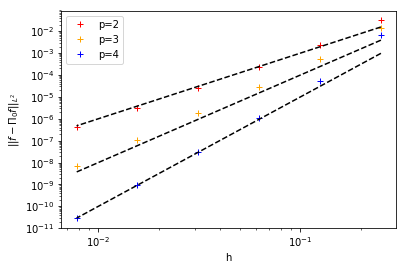

In [78]:
colors = ['red', 'orange', 'blue', 'green']
labels = ['p=2', 'p=3', 'p=4', 'p=5']

for ip in range(len(ps)):
    plt.loglog(hs[ip], errors[ip], 'k+', color=colors[ip], label=labels[ip])

plt.loglog(hs[0], hs[0]**3, 'k--')
plt.loglog(hs[0], hs[0]**4, 'k--')
plt.loglog(hs[0], hs[0]**5, 'k--')

plt.xlabel('h')
plt.ylabel('$||f-\Pi_0f||_{L^2}$')
plt.legend()

# 2. Convergence of projector $\Pi_0$ with intermediate projection on $V_1$

In [70]:
# now: test_fun lives in discrete space V1 and needs to be projected to V0 space
test_fun = lambda x : np.sin(2*np.pi*x)
Beq      = lambda x : np.cos(2*np.pi*x)
xplot = np.linspace(0., 1., 200)


Nels   = np.array([4, 8, 16, 32, 64, 128, 256, 512])
ps     = np.array([2, 3, 4])

hs     = np.zeros((len(ps), len(Nels)))
errors = np.zeros((len(ps), len(Nels)))

for ip in range(len(ps)):
    for ie in range(len(Nels)):

        Nel        = Nels[ie]                     # number of elements   
        bc         = True                         # boundary conditions (True: periodic, False: else)
        p          = int(ps[ip])                  # spline degres  

        el_b       = np.linspace(0., 1., Nel + 1) # element boundaries
        hs[ip, ie] = 1/Nel                        # element size
        T          = bsp.make_knots(el_b, p, bc)  # knot vector (for N functions)
        t          = T[1:-1]                      # reduced knot vector (for D function)
        NbaseN     = Nel + p - bc*p               # number of basis functions (N functions)
        NbaseD     = NbaseN - (1 - bc)            # number of basis functions (D functions)
        
        # projector
        proj_glob = proj_global.projectors_1d(T, p, bc)
        #proj_loc  = proj_local.projectors_local_1d(T, p, bc)

        # assemble interpolation and histopolation matrix for global projector
        proj_glob.assemble_V0()
        proj_glob.assemble_V1()
        
        # project test_fun on V1
        coeff_V1 = proj_glob.PI_1(test_fun)
        
        def test_fun_V1(x):
    
            if isinstance(x, np.ndarray):
                D = bsp.collocation_matrix(t, p - 1, x, bc, normalize=True)
                return D.dot(coeff_V1) * Beq(x)

            else:
                D = bsp.collocation_matrix(t, p - 1, np.array([x]), bc, normalize=True)[0]
                return D.dot(coeff_V1) * Beq(x)
        
        coeff_V0 = proj_glob.PI_0(test_fun_V1)
        
        errors[ip, ie] = mass.L2_error_V0_1d(coeff_V0, T, p, bc, lambda x : test_fun(x)*Beq(x))

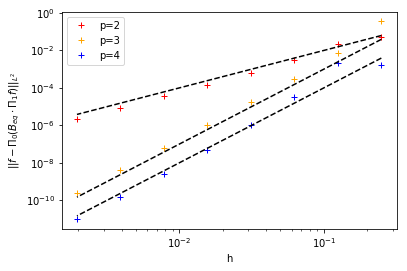

In [78]:
colors = ['red', 'orange', 'blue', 'green']
labels = ['p=2', 'p=3', 'p=4', 'p=5']

for ip in range(len(ps)):
    plt.loglog(hs[ip], errors[ip], 'k+', color=colors[ip], label=labels[ip])

plt.loglog(hs[0], 1e0*hs[0]**2, 'k--')
plt.loglog(hs[0], 1e1*hs[0]**4, 'k--')
plt.loglog(hs[0], 1e0*hs[0]**4, 'k--')

plt.xlabel('h')
plt.ylabel('$||f-\Pi_0(B_{eq}\cdot\Pi_1f)||_{L^2}$')
plt.legend()

# 3. $L^2$-projection of advective term

We want to approximate the function $f(x) = \frac{\mathrm{d}}{\mathrm{d}x}\left[a(x)u(x)\right]$ with $u\in L^2$ using a $L^2-$projection: find $f_h\in V_1$ such that

$$
(f-f_h,c_h)=0 \qquad\forall c_h\in V_1, \\
\int_0^1 f_h(x)c_h(x)\mathrm{d}x=\int_0^1 \frac{\mathrm{d}}{\mathrm{d}x}\left[a(x)u(x)\right]c_h(x)\mathrm{d}x \qquad\forall c_h\in V_1. \\
$$

We assume that $u$ is given by an approximation $u_h\in V_1$ from some other equation (e.g. momentum equation) and $a$ is a continuous field representing for instance an equilibrium quantitiy or a material property. We can compute the right-hand side in two different ways. Either we leave it as it is,

$$
\int_0^1 c_h(x)\frac{\mathrm{d}}{\mathrm{d}x}[a(x)u_h(x)]\mathrm{d}x=\sum_{ij}c_iu_j\int_0^1\varphi^1_i(x)\left(\frac{\mathrm{d}a}{\mathrm{d}x}\varphi^1_j(x)+a(x)\frac{\mathrm{d}\varphi_j^1(x)}{\mathrm{d}x}\right)\mathrm{d}x=:\mathbf{c}^\top(\mathbb{A} + \mathbb{K})\mathbf{u} \qquad \forall\mathbf{u}\in\mathbb{R}^N,
$$

or we project the term $a(x)u_h(x)\notin V_1$ back into $V_0$ so that we can apply the derivative:

$$
\int_0^1 c_h(x)\frac{\mathrm{d}}{\mathrm{d}x}\Pi_0[a(x)u_h(x)]\mathrm{d}x=\sum_{ij}c_iu_j\int_0^1 \varphi^1_i(x)\frac{\mathrm{d}}{\mathrm{d}x}\Pi_0[a(x)\varphi^1_j(x)]\mathrm{d}x=\mathbf{c}^\top\mathbb{M}^1\mathbb{G}\mathcal{T}\mathbf{u}\qquad \forall\mathbf{c}\in\mathbb{R}^N.
$$

The matrix $\mathcal{T}_{ij}=\Pi_0^i(a(x)\varphi^1_j(x))$, i.e. it gives the i-th coefficient in the basis of $V_0$ of the j-th weighted basis function $a(x)\varphi^1_j(x)$.

Hence we get the two set of coefficients

$$
\mathbf{f}^\mathrm{ref}=\mathbb{M}_1^{-1}(\mathbb{A}+\mathbb{K})\mathbf{u}, \\
\mathbf{f}=\mathbb{G}\mathcal{T}\mathbf{u},
$$

whose difference we can measure in the $L^2$-norm as we refine the mesh:

$$
||f_h^\mathrm{ref}-f_h||^2_{L^2} = \int_0^1(f_h^\mathrm{ref}-f_h)^2\mathrm{d}x=(\mathbf{f}^\mathrm{ref} - \mathbf{f})^\top\mathbb{M}_1(\mathbf{f}^\mathrm{ref} - \mathbf{f}).
$$

In [79]:
# ================================================ A matrix in V1 (1d) ====================================================
def A_mat(T, p, bc, d_fun):
    '''
    Computes the sparse 1d mass matrix (DD) of the given spline space of degree p.
    '''
    
    t                = T[1:-1]
    
    el_b             = bsp.breakpoints(T, p)
    Nel              = len(el_b) - 1
    NbaseN           = Nel + p - bc*p
    NbaseD           = NbaseN - (1 - bc)
    
    pts_loc, wts_loc = np.polynomial.legendre.leggauss(p + 1)
    pts,     wts     = bsp.quadrature_grid(el_b, pts_loc, wts_loc)

    basisD           = bsp.basis_ders_on_quad_grid(t, p - 1, pts, 0, normalize=True)
    
    M                = np.zeros((NbaseD, 2*p + 1))

    for ie in range(Nel):

        for il in range(p):
            for jl in range(p):

                value = 0.

                for q in range(p + 1):
                    value += wts[ie, q] * basisD[ie, il, 0, q] * basisD[ie, jl, 0, q] * d_fun(pts[ie, q])

                M[(ie + il)%NbaseD, p + jl - il] += value
                
    
    indices = np.indices((NbaseD, 2*p + 1))
    shift   = np.arange(NbaseD) - p

    row     = indices[0].flatten()
    col     = (indices[1] + shift[:, None])%NbaseD
    
    M       = spa.csr_matrix((M.flatten(), (row, col.flatten())), shape=(NbaseD, NbaseD))
    M.eliminate_zeros()
                
    return M
# ============================================================================================================================


# ================================================ K matrix in V1 (1d) ====================================================
def K_mat(T, p, bc, fun):
    '''
    Computes the sparse 1d mass matrix (DD) of the given spline space of degree p.
    '''
    
    t                = T[1:-1]
    
    el_b             = bsp.breakpoints(T, p)
    Nel              = len(el_b) - 1
    NbaseN           = Nel + p - bc*p
    NbaseD           = NbaseN - (1 - bc)
    
    pts_loc, wts_loc = np.polynomial.legendre.leggauss(p + 1)
    pts,     wts     = bsp.quadrature_grid(el_b, pts_loc, wts_loc)

    basisD           = bsp.basis_ders_on_quad_grid(t, p - 1, pts, 1, normalize=True)
    
    M                = np.zeros((NbaseD, 2*p + 1))

    for ie in range(Nel):

        for il in range(p):
            for jl in range(p):

                value = 0.

                for q in range(p + 1):
                    value += wts[ie, q] * basisD[ie, il, 0, q] * basisD[ie, jl, 1, q] * fun(pts[ie, q])

                M[(ie + il)%NbaseD, p + jl - il] += value
                
    
    indices = np.indices((NbaseD, 2*p + 1))
    shift   = np.arange(NbaseD) - p

    row     = indices[0].flatten()
    col     = (indices[1] + shift[:, None])%NbaseD
    
    M       = spa.csr_matrix((M.flatten(), (row, col.flatten())), shape=(NbaseD, NbaseD))
    M.eliminate_zeros()
                
    return M
# ============================================================================================================================

In [80]:
Nel       = 128                          # number of elements   
bc        = True                         # boundary conditions (True: periodic, False: else)
p         = 3                            # spline degres  

el_b      = np.linspace(0., 1., Nel + 1) # element boundaries
delta     = 1/Nel                        # element size
T         = bsp.make_knots(el_b, p, bc)  # knot vector (for N functions)
t         = T[1:-1]                      # reduced knot vector (for D function)
NbaseN    = Nel + p - bc*p               # number of basis functions (N functions)
NbaseD    = NbaseN - (1 - bc)            # number of basis functions (D functions)

xplot = np.linspace(0., 1., 200)

# projector
proj_glob = proj_global.projectors_1d(T, p, bc)
proj_loc  = proj_local.projectors_local_1d(T, p, bc)

# assemble interpolation and histopolation matrix for global projector
proj_glob.assemble_V0()
proj_glob.assemble_V1()

In [81]:
u_tilde   = lambda x :  np.sin(2*np.pi*x)
d_u_tilde = lambda x :  np.cos(2*np.pi*x)*2*np.pi

omega     = 4.
rho_eq    = lambda x :  np.cos(omega*np.pi*x)
d_rho_eq  = lambda x : -np.sin(omega*np.pi*x)*omega*np.pi

result    = lambda x :  d_rho_eq(x)*u_tilde(x) + rho_eq(x)*d_u_tilde(x)

u_coeff   = proj_glob.PI_1(u_tilde)


A = A_mat(T, p, bc, d_rho_eq)
K = K_mat(T, p, bc, rho_eq)

M0 = mass.mass_1d_NN(T, p, bc)
M1 = mass.mass_1d_DD(T, p, bc)
G  = der.GRAD_1d(T, p, bc)

tau = np.zeros((NbaseN, NbaseD))

N = bspline.Bspline(T, p)
D = bspline.Bspline(t, p - 1) 

for j in range(NbaseD):
    
    if j < (p - 1):
        fun = lambda x : rho_eq(x) * (D(x, j)/delta + D(x, NbaseD + j )/delta)
    else:
        fun = lambda x : rho_eq(x) *  D(x, j)/delta
    
    tau[:, j] = proj_glob.PI_0(fun)

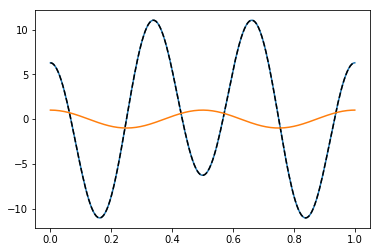

In [82]:
coeff1 = np.linalg.solve(M1.toarray(), (A + K).dot(u_coeff))
res    = eva.FEM_field_V1_1d(coeff1, xplot, T, p, bc)

plt.plot(xplot, res)
plt.plot(xplot, result(xplot), 'k--')
plt.plot(xplot, rho_eq(xplot))

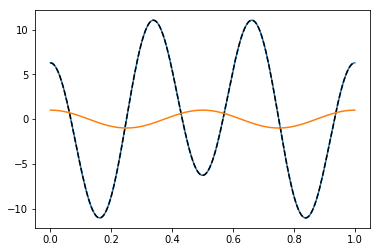

In [83]:
coeff2 = G.dot(tau.dot(u_coeff))
res    = eva.FEM_field_V1_1d(coeff2, xplot, T, p, bc)

plt.plot(xplot, res)
plt.plot(xplot, result(xplot), 'k--')
plt.plot(xplot, rho_eq(xplot))

In [84]:
print(mass.L2_error_V1_1d(coeff1, T, p, bc, result))
print(mass.L2_error_V1_1d(coeff2, T, p, bc, result))

0.00012309521877269805
0.00012318072019421088


In [85]:
# convergence test
Nels   = np.array([8, 16, 32, 64, 128, 256, 512])
ps     = np.array([2, 3, 4, 5])

hs     = np.zeros((len(ps), len(Nels)))
errors = np.zeros((len(ps), len(Nels)))

u_tilde   = lambda x :  np.sin(2*np.pi*x)
d_u_tilde = lambda x :  np.cos(2*np.pi*x)*2*np.pi

omega     = 4.
rho_eq    = lambda x :  np.cos(omega*np.pi*x)
d_rho_eq  = lambda x : -np.sin(omega*np.pi*x)*omega*np.pi

result    = lambda x :  d_rho_eq(x)*u_tilde(x) + rho_eq(x)*d_u_tilde(x)


for ip in range(len(ps)):
    for ie in range(len(Nels)):

        Nel        = Nels[ie]                     # number of elements   
        bc         = True                         # boundary conditions (True: periodic, False: else)
        p          = int(ps[ip])                  # spline degres  

        el_b       = np.linspace(0., 1., Nel + 1) # element boundaries
        hs[ip, ie] = 1/Nel                        # element size
        T          = bsp.make_knots(el_b, p, bc)  # knot vector (for N functions)
        t          = T[1:-1]                      # reduced knot vector (for D function)
        NbaseN     = Nel + p - bc*p               # number of basis functions (N functions)
        NbaseD     = NbaseN - (1 - bc)            # number of basis functions (D functions)
        
        # projector
        proj_glob = proj_global.projectors_1d(T, p, bc)
        proj_loc  = proj_local.projectors_local_1d(T, p, bc)

        # assemble interpolation and histopolation matrix for global projector
        proj_glob.assemble_V0()
        proj_glob.assemble_V1()
        
        
        u_coeff   = proj_glob.PI_1(u_tilde)

        A = A_mat(T, p, bc, d_rho_eq)
        K = K_mat(T, p, bc, rho_eq)

        M0 = mass.mass_1d_NN(T, p, bc)
        M1 = mass.mass_1d_DD(T, p, bc)
        G  = der.GRAD_1d(T, p, bc)

        tau = np.zeros((NbaseN, NbaseD))

        N = bspline.Bspline(T, p)
        D = bspline.Bspline(t, p - 1) 

        for j in range(NbaseD):

            if j < (p - 1):
                fun = lambda x : rho_eq(x) * (D(x, j)/hs[ip, ie] + D(x, NbaseD + j )/hs[ip, ie])
            else:
                fun = lambda x : rho_eq(x) *  D(x, j)/hs[ip, ie]

            tau[:, j] = proj_glob.PI_0(fun)
            
        coeff1 = np.linalg.solve(M1.toarray(), (A + K).dot(u_coeff))
        coeff2 = G.dot(tau.dot(u_coeff))
            
        errors[ip, ie] = np.sqrt((coeff1 - coeff2).dot(M1.dot(coeff1 - coeff2)))

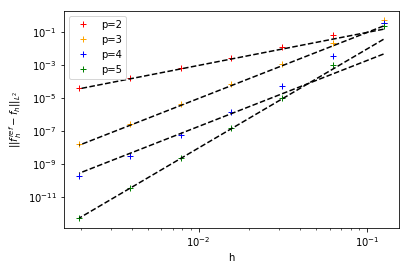

In [90]:
colors = ['red', 'orange', 'blue', 'green']
labels = ['p=2', 'p=3', 'p=4', 'p=5']

for ip in range(len(ps)):
    plt.loglog(hs[ip], errors[ip], '+', color = colors[ip], label=labels[ip])
    
plt.loglog(hs[0], 1e1*hs[0]**2, 'k--')
plt.loglog(hs[0], 1e3*hs[0]**4, 'k--')
plt.loglog(hs[0], 2e1*hs[0]**4, 'k--')
plt.loglog(hs[0], 1e4*hs[0]**6, 'k--')

plt.xlabel('h')
plt.ylabel('$||f^{ref}_h-f_h||_{L^2}$')
plt.legend()

# 4. $L^2$ projection of advective term (weak)

We want to approximate the function $f(x) = a(x)\frac{\mathrm{d}B}{\mathrm{d}x}$ with $B\in L^2$ using a $L^2-$projection: find $f_h\in V_0$ such that

$$
(f-f_h,c_h)=0 \qquad\forall c_h\in V_0, \\
\int_0^1 f_h(x)c_h(x)\mathrm{d}x=\int_0^1 a(x)\frac{\mathrm{d}B}{\mathrm{d}x}c_h(x)\mathrm{d}x=-\int_0^1 B(x)\frac{\mathrm{d}}{\mathrm{d}x}[a(x)c_h(x)]\mathrm{d}x \qquad\forall c_h\in V_0. \\
$$

We assume that $B$ is given by an approximation $B_h\in V_1$ and $a$ is a continuous field representing for instance an equilibrium quantitiy or a material property. We can compute the right-hand side in two different ways. Either we leave it as it is,

$$
-\int_0^1 B_h(x)\frac{\mathrm{d}}{\mathrm{d}x}[a(x)c_h(x)]\mathrm{d}x=-\sum_{ij}c_ib_j\int_0^1\left(\frac{\mathrm{d}a}{\mathrm{d}x}\varphi^0_i(x)+a(x)\frac{\mathrm{d}\varphi_i^0(x)}{\mathrm{d}x}\right)\varphi^1_j(x)\mathrm{d}x=:-\mathbf{c}^\top(\mathbb{A} + \mathbb{K})\mathbf{b} \qquad \forall\mathbf{c}\in\mathbb{R}^N,
$$

or we project the term $a(x)c_h(x)\notin V_0$ back into $V_0$:

$$
-\int_0^1 B_h(x)\frac{\mathrm{d}}{\mathrm{d}x}\Pi_0[a(x)c_h(x)]\mathrm{d}x=-\sum_{ij}b_ic_j\int_0^1 \varphi^1_i(x)\frac{\mathrm{d}}{\mathrm{d}x}\Pi_0[a(x)\varphi^0_j(x)]\mathrm{d}x=-\mathbf{b}^\top\mathbb{M}^1\mathbb{G}\mathcal{T}\mathbf{c}\qquad \forall\mathbf{c}\in\mathbb{R}^N.
$$

The matrix $\mathcal{T}_{ij}=\Pi_0^i(a(x)\varphi^0_j(x))$, i.e. it gives the i-th coefficient in the basis of $V_0$ of the j-th weighted basis function $a(x)\varphi^0_j(x)$.

Hence we get the two set of coefficients

$$
\mathbf{f}^\mathrm{ref}=-\mathbb{M}_0^{-1}(\mathbb{A}+\mathbb{K})\mathbf{b}, \\
\mathbf{f}=-\mathbb{M}_0^{-1}\mathcal{T}^\top\mathbb{G}^\top\mathbb{M}^1\mathbf{b},
$$

whose difference we can measure in the $L^2$-norm as we refine the mesh:

$$
||f_h^\mathrm{ref}-f_h||^2_{L^2} = \int_0^1(f_h^\mathrm{ref}-f_h)^2\mathrm{d}x=(\mathbf{f}^\mathrm{ref} - \mathbf{f})^\top\mathbb{M}_0(\mathbf{f}^\mathrm{ref} - \mathbf{f}).
$$

In [5]:
# =============================================== A matrix in V0/V1 (ND) (1d) =============================================
def A_mat(T, p, bc, d_fun):
    
    t                = T[1:-1]
    
    el_b             = bsp.breakpoints(T, p)
    Nel              = len(el_b) - 1
    NbaseN           = Nel + p - bc*p
    NbaseD           = NbaseN - (1 - bc)
    
    pts_loc, wts_loc = np.polynomial.legendre.leggauss(p + 1)
    pts,     wts     = bsp.quadrature_grid(el_b, pts_loc, wts_loc)

    basisN           = bsp.basis_ders_on_quad_grid(T, p, pts, 0)
    basisD           = bsp.basis_ders_on_quad_grid(t, p - 1, pts, 0, normalize=True)
    
    M                = np.zeros((NbaseN, 2*p + 1))

    for ie in range(Nel):

        for il in range(p + 1):
            for jl in range(p):

                value = 0.

                for q in range(p + 1):
                    value += wts[ie, q] * basisN[ie, il, 0, q] * basisD[ie, jl, 0, q] * d_fun(pts[ie, q])

                M[(ie + il)%NbaseN, p + jl - il] += value
                
    
    indices = np.indices((NbaseN, 2*p + 1))
    shift   = np.arange(NbaseN) - p

    row     = indices[0].flatten()
    col     = (indices[1] + shift[:, None])%NbaseD
    
    M       = spa.csr_matrix((M.flatten(), (row, col.flatten())), shape=(NbaseN, NbaseD))
    M.eliminate_zeros()
                
    return M
# ============================================================================================================================



# =============================================== K matrix in V0/V1 (ND) (1d) =============================================
def K_mat(T, p, bc, fun):
    
    t                = T[1:-1]
    
    el_b             = bsp.breakpoints(T, p)
    Nel              = len(el_b) - 1
    NbaseN           = Nel + p - bc*p
    NbaseD           = NbaseN - (1 - bc)
    
    pts_loc, wts_loc = np.polynomial.legendre.leggauss(p + 1)
    pts,     wts     = bsp.quadrature_grid(el_b, pts_loc, wts_loc)

    basisN           = bsp.basis_ders_on_quad_grid(T, p, pts, 1)
    basisD           = bsp.basis_ders_on_quad_grid(t, p - 1, pts, 0, normalize=True)
    
    M                = np.zeros((NbaseN, 2*p + 1))

    for ie in range(Nel):

        for il in range(p + 1):
            for jl in range(p):

                value = 0.

                for q in range(p + 1):
                    value += wts[ie, q] * basisN[ie, il, 1, q] * basisD[ie, jl, 0, q] * fun(pts[ie, q])

                M[(ie + il)%NbaseN, p + jl - il] += value
                
    
    indices = np.indices((NbaseN, 2*p + 1))
    shift   = np.arange(NbaseN) - p

    row     = indices[0].flatten()
    col     = (indices[1] + shift[:, None])%NbaseD
    
    M       = spa.csr_matrix((M.flatten(), (row, col.flatten())), shape=(NbaseN, NbaseD))
    M.eliminate_zeros()
                
    return M
# ============================================================================================================================

In [90]:
Nel       = 512                           # number of elements   
bc        = True                         # boundary conditions (True: periodic, False: else)
p         = 5                            # spline degres  

el_b      = np.linspace(0., 1., Nel + 1) # element boundaries
delta     = 1/Nel                        # element size
T         = bsp.make_knots(el_b, p, bc)  # knot vector (for N functions)
t         = T[1:-1]                      # reduced knot vector (for D function)
NbaseN    = Nel + p - bc*p               # number of basis functions (N functions)
NbaseD    = NbaseN - (1 - bc)            # number of basis functions (D functions)

xplot = np.linspace(0., 1., 200)

# projector
proj_glob = proj_global.projectors_1d(T, p, bc)
proj_loc  = proj_local.projectors_local_1d(T, p, bc)

# assemble interpolation and histopolation matrix for global projector
proj_glob.assemble_V0()
proj_glob.assemble_V1()

In [91]:
B_tilde = lambda x :  np.sin(2*np.pi*x)


omega   = 6.

Beq     = lambda x :  np.cos(omega*np.pi*x)
d_Beq   = lambda x : -np.sin(omega*np.pi*x)*omega*np.pi

#Beq     = lambda x :  np.abs(np.cos(omega*np.pi*x))
#d_Beq   = lambda x : -np.sin(omega*np.pi*x)*omega*np.pi*np.cos(omega*np.pi*x)/np.abs(np.cos(omega*np.pi*x))

result  = lambda x : Beq(x)*np.cos(2*np.pi*x)*2*np.pi

b_coeff = proj_glob.PI_1(B_tilde)


A = A_mat(T, p, bc, d_Beq)
K = K_mat(T, p, bc, Beq)

M0 = mass.mass_1d_NN(T, p, bc)
M1 = mass.mass_1d_DD(T, p, bc)
G  = der.GRAD_1d(T, p, bc)

tau = np.zeros((NbaseN, NbaseN))

N = bspline.Bspline(T, p)
D = bspline.Bspline(t, p - 1) 

for j in range(NbaseN):
    
    if j < p:
        fun = lambda x : Beq(x) * (N(x, j) + N(x, NbaseN + j ))
    else:
        fun = lambda x : Beq(x) *  N(x, j)
    
    tau[:, j] = proj_glob.PI_0(fun)

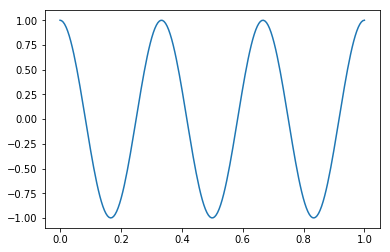

In [92]:
plt.plot(xplot, Beq(xplot))

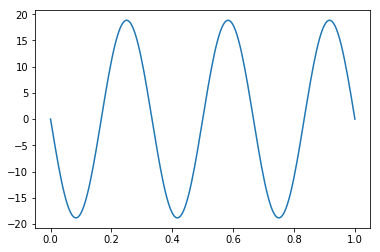

In [93]:
plt.plot(xplot, d_Beq(xplot))

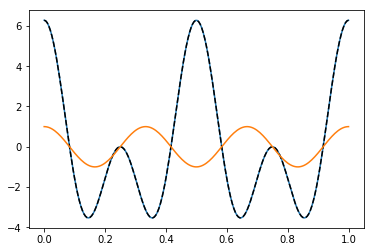

In [94]:
coeff1 = np.linalg.solve(M0.toarray(), -(A + K).dot(b_coeff))
res   = eva.FEM_field_V0_1d(coeff1, xplot, T, p, bc)

plt.plot(xplot, res)
plt.plot(xplot, result(xplot), 'k--')
plt.plot(xplot, Beq(xplot))

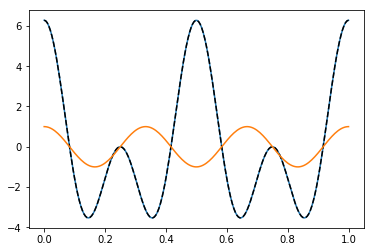

In [95]:
coeff2 = np.linalg.solve(M0.toarray(), -tau.T.dot(G.T.dot(M1.dot(b_coeff))))
res   = eva.FEM_field_V0_1d(coeff2, xplot, T, p, bc)

plt.plot(xplot, res)
plt.plot(xplot, result(xplot), 'k--')
plt.plot(xplot, Beq(xplot))

In [96]:
print(mass.L2_error_V0_1d(coeff1, T, p, bc, result))
print(mass.L2_error_V0_1d(coeff2, T, p, bc, result))

7.329717284678394e-13
1.2709066160181334e-12


In [136]:
# covergence test
Nels   = np.array([8, 16, 32, 64, 128, 256, 512])
ps     = np.array([2, 3, 4, 5])

hs     = np.zeros((len(ps), len(Nels)))
errors = np.zeros((len(ps), len(Nels)))

errors_meth1 = np.zeros((len(ps), len(Nels)))
errors_meth2 = np.zeros((len(ps), len(Nels)))

B_tilde = lambda x :  np.sin(2*np.pi*x)


omega   = 6.

Beq     = lambda x :  np.cos(omega*np.pi*x)
d_Beq   = lambda x : -np.sin(omega*np.pi*x)*omega*np.pi

#Beq     = lambda x :  np.abs(np.cos(omega*np.pi*x))
#d_Beq   = lambda x : -np.sin(omega*np.pi*x)*omega*np.pi*np.cos(omega*np.pi*x)/np.abs(np.cos(omega*np.pi*x))

result  = lambda x : Beq(x)*np.cos(2*np.pi*x)*2*np.pi

for ip in range(len(ps)):
    for ie in range(len(Nels)):

        Nel        = Nels[ie]                     # number of elements   
        bc         = True                         # boundary conditions (True: periodic, False: else)
        p          = int(ps[ip])                  # spline degres  

        el_b       = np.linspace(0., 1., Nel + 1) # element boundaries
        hs[ip, ie] = 1/Nel                        # element size
        T          = bsp.make_knots(el_b, p, bc)  # knot vector (for N functions)
        t          = T[1:-1]                      # reduced knot vector (for D function)
        NbaseN     = Nel + p - bc*p               # number of basis functions (N functions)
        NbaseD     = NbaseN - (1 - bc)            # number of basis functions (D functions)
        
        # projector
        proj_glob = proj_global.projectors_1d(T, p, bc)
        #proj_loc  = proj_local.projectors_local_1d(T, p, bc)

        # assemble interpolation and histopolation matrix for global projector
        proj_glob.assemble_V0()
        proj_glob.assemble_V1()
        
        b_coeff = proj_glob.PI_1(B_tilde)

        A = A_mat(T, p, bc, d_Beq)
        K = K_mat(T, p, bc, Beq)

        M0 = mass.mass_1d_NN(T, p, bc)
        M1 = mass.mass_1d_DD(T, p, bc)
        G  = der.GRAD_1d(T, p, bc)

        tau = np.zeros((NbaseN, NbaseN))

        N = bspline.Bspline(T, p)
        D = bspline.Bspline(t, p - 1) 

        for j in range(NbaseN):

            if j < p:
                fun = lambda x : Beq(x) * (N(x, j) + N(x, NbaseN + j ))
            else:
                fun = lambda x : Beq(x) *  N(x, j)

            tau[:, j] = proj_glob.PI_0(fun)
            
        coeff1 = np.linalg.solve(M0.toarray(), -(A + K).dot(b_coeff))
        coeff2 = np.linalg.solve(M0.toarray(), -tau.T.dot(G.T.dot(M1.dot(b_coeff))))
            
        errors[ip, ie] = np.sqrt((coeff1 - coeff2).dot(M0.dot(coeff1 - coeff2)))
        
        errors_meth1[ip, ie] = mass.L2_error_V0_1d(coeff1, T, p, bc, result)
        errors_meth2[ip, ie] = mass.L2_error_V0_1d(coeff2, T, p, bc, result)

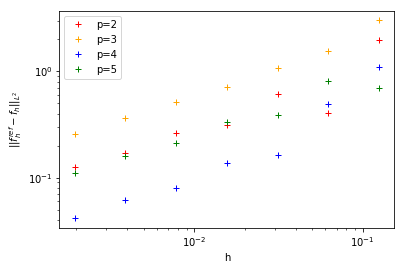

In [124]:
colors = ['red', 'orange', 'blue', 'green']
labels = ['p=2', 'p=3', 'p=4', 'p=5']

for ip in range(len(ps)):
    plt.loglog(hs[ip], errors[ip], '+', color = colors[ip], label=labels[ip])
    
#plt.loglog(hs[0], 1e1*hs[0]**3, 'k--')
#plt.loglog(hs[0], 1e3*hs[0]**4, 'k--')
#plt.loglog(hs[0], 2e1*hs[0]**4, 'k--')
#plt.loglog(hs[0], 1e4*hs[0]**6, 'k--')

plt.xlabel('h')
plt.ylabel('$||f^{ref}_h-f_h||_{L^2}$')
plt.legend()

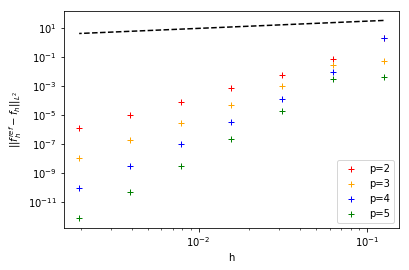

In [141]:
colors = ['red', 'orange', 'blue', 'green']
labels = ['p=2', 'p=3', 'p=4', 'p=5']

for ip in range(len(ps)):
    plt.loglog(hs[ip], errors_meth1[ip], '+', color = colors[ip], label=labels[ip])
    

plt.loglog(hs[0], 1e2*hs[0]**0.5, 'k--')
#plt.loglog(hs[0], 1e3*hs[0]**4, 'k--')
#plt.loglog(hs[0], 2e3*hs[0]**5, 'k--')
#plt.loglog(hs[0], 2e4*hs[0]**6, 'k--')

plt.xlabel('h')
plt.ylabel('$||f^{ref}_h-f_h||_{L^2}$')
plt.legend()

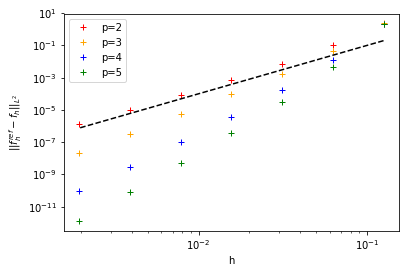

In [140]:
colors = ['red', 'orange', 'blue', 'green']
labels = ['p=2', 'p=3', 'p=4', 'p=5']

for ip in range(len(ps)):
    plt.loglog(hs[ip], errors_meth2[ip], '+', color = colors[ip], label=labels[ip])
    
plt.loglog(hs[0], 1e2*hs[0]**3, 'k--')
#plt.loglog(hs[0], 1e3*hs[0]**4, 'k--')
#plt.loglog(hs[0], 2e3*hs[0]**5, 'k--')
#plt.loglog(hs[0], 2e4*hs[0]**6, 'k--')

plt.xlabel('h')
plt.ylabel('$||f^{ref}_h-f_h||_{L^2}$')
plt.legend()

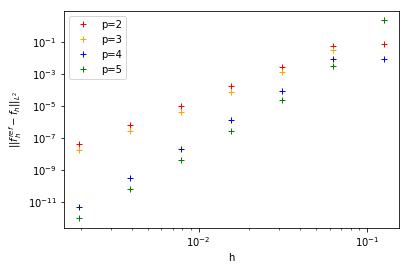

In [139]:
colors = ['red', 'orange', 'blue', 'green']
labels = ['p=2', 'p=3', 'p=4', 'p=5']

for ip in range(len(ps)):
    plt.loglog(hs[ip], errors[ip], '+', color = colors[ip], label=labels[ip])
    
#plt.loglog(hs[0], 1e1*hs[0]**3, 'k--')
#plt.loglog(hs[0], 1e3*hs[0]**4, 'k--')
#plt.loglog(hs[0], 2e1*hs[0]**4, 'k--')
#plt.loglog(hs[0], 1e4*hs[0]**6, 'k--')

plt.xlabel('h')
plt.ylabel('$||f^{ref}_h-f_h||_{L^2}$')
plt.legend()

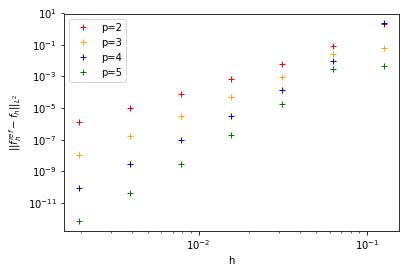

In [137]:
colors = ['red', 'orange', 'blue', 'green']
labels = ['p=2', 'p=3', 'p=4', 'p=5']

for ip in range(len(ps)):
    plt.loglog(hs[ip], errors_meth1[ip], '+', color = colors[ip], label=labels[ip])
    
#plt.loglog(hs[0], 1e2*hs[0]**0.5, 'k--')
#plt.loglog(hs[0], 1e3*hs[0]**4, 'k--')
#plt.loglog(hs[0], 2e3*hs[0]**5, 'k--')
#plt.loglog(hs[0], 2e4*hs[0]**6, 'k--')

plt.xlabel('h')
plt.ylabel('$||f^{ref}_h-f_h||_{L^2}$')
plt.legend()

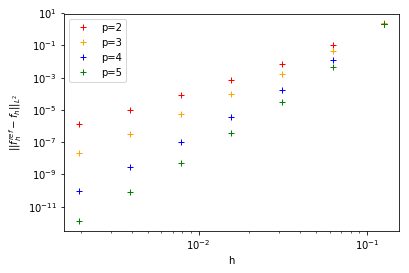

In [138]:
colors = ['red', 'orange', 'blue', 'green']
labels = ['p=2', 'p=3', 'p=4', 'p=5']

for ip in range(len(ps)):
    plt.loglog(hs[ip], errors_meth2[ip], '+', color = colors[ip], label=labels[ip])
    
#plt.loglog(hs[0], 1e2*hs[0]**0.5, 'k--')
#plt.loglog(hs[0], 1e3*hs[0]**4, 'k--')
#plt.loglog(hs[0], 2e3*hs[0]**5, 'k--')
#plt.loglog(hs[0], 2e4*hs[0]**6, 'k--')

plt.xlabel('h')
plt.ylabel('$||f^{ref}_h-f_h||_{L^2}$')
plt.legend()

In [215]:
L = 10.

n = 4
fun = lambda x : np.sin(n*2*np.pi*x/L)

Nx  = 50
pts = np.linspace(0., 1., Nx + 1)

In [216]:
freq = np.linspace(0, Nx, Nx + 1) - Nx/2
freq = 2*np.pi*freq/L

f_fft = np.fft.fftshift(np.fft.fft(fun(pts)))

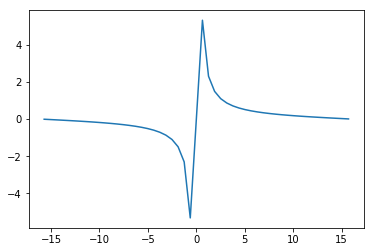

In [221]:
plt.plot(freq, np.imag(f_fft))

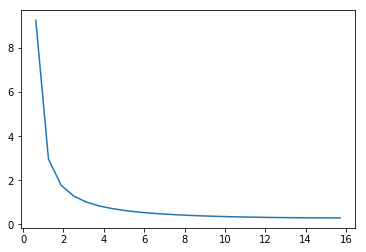

In [232]:
test = np.fft.rfft(fun(pts))

freq = np.arange(Nx/2) + 1
freq = 2*np.pi*freq/L

plt.plot(freq, np.abs(test)[1:])

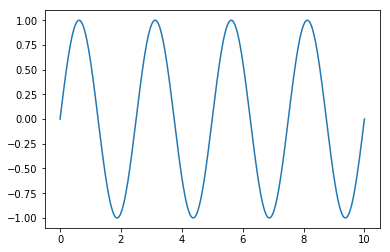

In [213]:
xplot = np.linspace(0., L, 500)
plt.plot(xplot, fun(xplot))

In [229]:
np.arange(Nx/2) + 1

array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
       14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25.])